## This analysis is using the first day exposed users as cohort to evaluate how much impact Chat Channel product to Reddit users on ToS/posts/posts consumed/comments/comments consumed.

* query and work sheet: [link](https://docs.google.com/spreadsheets/d/1Sna_u-3IhXGr_vy1Z_eIbzrUBXcNlmjUrulpX4x1ML4/edit?gid=803898469#gid=803898469)
* analysis: [link](https://docs.google.com/document/d/1UigQy_y2aKefvjr90ouheZFQb9fwFXKX4FTdM-K_hzE/edit#heading=h.b2s919pgr6j)
* Chat Holdout Post analysis proposal: [link](https://docs.google.com/document/d/1L2eQ5qLfvmv2oNWhXvXvRUzVOHwuDcPC73XYUBm3kvU/edit)
* Notes - Kickoff Holdout for Chat Project: [link](https://docs.google.com/document/d/18bL_COuoRoJwH7wggnfpfL-w4803-j_fazjDvSLn-nM/edit#heading=h.cn28gfy79m8o)

In [1]:
!pip install google-cloud-bigquery
!pip install psmpy
# !pip install ace_tools

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from google.cloud import bigquery
pd.set_option('display.max_rows', None)

# Query large BQ table
project_id = 'data-prod-165221'
client = bigquery.Client(project=project_id)

Authenticated


# SQL

In [2]:
sql = '''
SELECT
    *
  FROM
   `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_0329_bets_chat_channels_holdout_exposed_users_step4_new_CC_v1` -- added comments/posts/tos as confounding factors
   left join  `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_0319cohort_bets_chat_channels_holdout_l28` using(user_id)
   left join `data-prod-165221.swat_tables.dim_user_reputation_scores_latest` using(user_id)
   left join `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_20240328_chat_holdout_sessions` using(user_id)
  WHERE 1=1
    AND user_logged_in = 1
    AND app_install = 1
    AND (ios_l1 > 0 OR android_l1 > 0)

'''
df = client.query(sql).to_dataframe()


sql = '''
select * from `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_0329_bets_chat_channels_holdout_tos`
'''

tos = client.query(sql).to_dataframe()

data frame size:
(224783, 38)
holdout group size
is_cc_active
0    112616
dtype: int64
non-holdout group size
is_cc_active
0    111503
1       645
dtype: int64
df_prep size:


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.7483, ROC AUC: 0.8029, F1-score: 0.0319


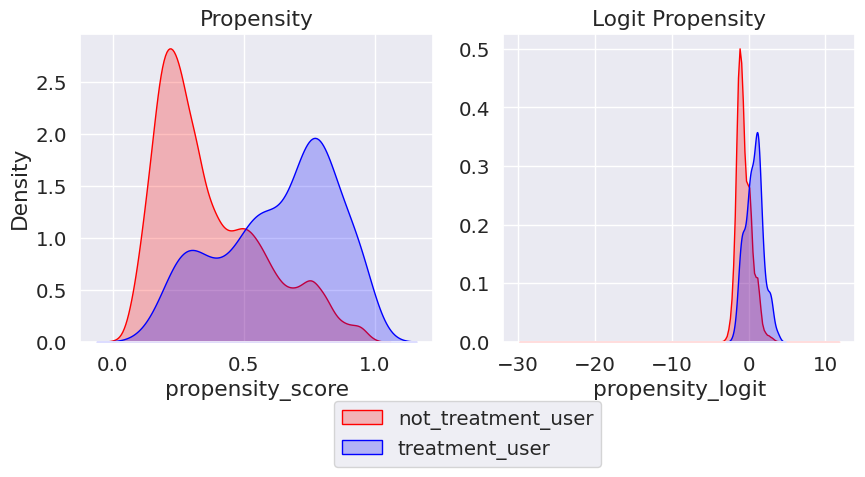

Performing KNN Matching on Propensity Scores........
Elapsed time: 125.055734 seconds


In [3]:
print('data frame size:')
print(df.shape)


from sklearn.preprocessing import OrdinalEncoder

# Create an OrdinalEncoder instance
encoder = OrdinalEncoder()

df['geo_dummy'] = encoder.fit_transform(df[['geo']])


# separate holdout and non-holdout group
print("holdout group size")
df_holdout = df[(df['experiment_variant'] == 'holdout') & (df['is_cc_active'] == 0)]

print(df_holdout.groupby('is_cc_active').size())

df_treatment = df[(df['experiment_variant'] == 'control_1')]
print("non-holdout group size")
print(df_treatment.groupby('is_cc_active').size())

# release more RAM by deleting table no longer use
# del df

## --------------------------------------------------------------------------------------------------------

"""
build a data frame including ony:
[holdout] holdout group: non-Chat Channel active users
[treatment] non-holdout group: Chat Channel active users ONLY
"""
df1 = df_treatment[df_treatment.is_cc_active==1]
df0 = df_holdout[df_holdout.is_cc_active==0]
frames = [df0, df1]
df_prep = pd.concat(frames)
print('df_prep size:')
df_prep.shape


# identifying two groups by assigning 0 or 1 to two group
df_test = df_prep.copy()
df_test['is_treatment'] = df_test['experiment_variant'].apply(lambda x: 0 if x == 'holdout' else 1)
# df_test = df_test.drop(columns=['experiment_variant','first_exposure_timestamp','is_cc_active']) # without geo
# df_test = df_test.drop(columns=['experiment_variant','first_exposure_timestamp','is_cc_active','geo'])
df_test = df_test.drop(columns=['experiment_variant','first_exposure_timestamp',
                                'is_cc_active','geo','pt','user_reputation_tier_v2', 'contributor_quality_tier'])
df_test = df_test.fillna(0)

from psmpy import PsmPy
from psmpy.functions import cohenD
import psmpy.plotting

# Predict Propensity Scores
psm = PsmPy(df_test, treatment='is_treatment', indx='user_id')
psm.logistic_ps(balance = True)

## --------------------------------------------------------------------------------------------------------

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# Add prediction column
predicted_df = psm.predicted_data
threshold = 0.5
predicted_df['pred'] = np.where(predicted_df['propensity_score']>=threshold, 1, 0)

# Assess the model
print(f"Accuracy: {np.mean(predicted_df['is_treatment']==predicted_df['pred']):.4f},\
 ROC AUC: {roc_auc_score(predicted_df['is_treatment'], predicted_df['propensity_score']):.4f},\
 F1-score: {f1_score(predicted_df['is_treatment'], predicted_df['pred']):.4f}")


## --------------------------------------------------------------------------------------------------------

import seaborn as sns

# Visualise confusion matrix
pd.crosstab(predicted_df['is_treatment'], predicted_df['pred']).rename(columns={0: False, 1: True})

# Update seaborn plotting code to use fill instead of shade
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Visualise propensity
sns.kdeplot(data=predicted_df[predicted_df['is_treatment'] == 0], x='propensity_score', fill=True,
            color='red', label='not_treatment_user', ax=ax[0])
sns.kdeplot(data=predicted_df[predicted_df['is_treatment'] == 1], x='propensity_score', fill=True,
            color='blue', label='treatment_user', ax=ax[0])
ax[0].set_title('Propensity')
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))

# Visualise logit propensity
sns.kdeplot(data=predicted_df[predicted_df['is_treatment'] == 0], x='propensity_logit', fill=True,
            color='red', label='not_treatment_user', ax=ax[1])
sns.kdeplot(data=predicted_df[predicted_df['is_treatment'] == 1], x='propensity_logit', fill=True,
            color='blue', label='treatment_user', ax=ax[1])
ax[1].set_title('Logit Propensity')
ax[1].set_ylabel("")

plt.show()


## --------------------------------------------------------------------------------------------------------

import time
# record the start time
start_time = time.perf_counter()
print("Performing KNN Matching on Propensity Scores........")

# Perform KNN Matching on Propensity Scores
psm.predicted_data.replace([np.inf, -np.inf], np.nan, inplace=True)
psm.predicted_data.dropna(inplace=True)
psm.knn_matched_12n(matcher='propensity_logit', how_many=1)

# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")





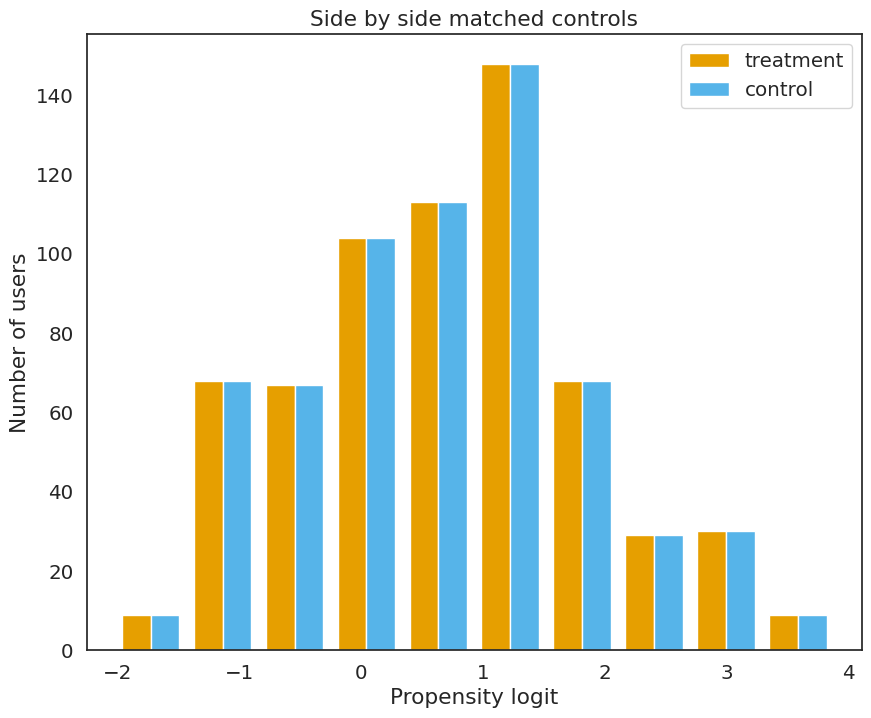

In [4]:

## --------------------------------------------------------------------------------------------------------

# Plot Propensity Scores
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of users', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)

View Matched IDs all users count:
(645, 2)
View unique IDs unique users count:
user_id               563
largerclass_0group    645
dtype: int64
View unique IDs Count after de-dup:
user_id               563
largerclass_0group    563
dtype: int64
Elapsed time: 0.005749 seconds


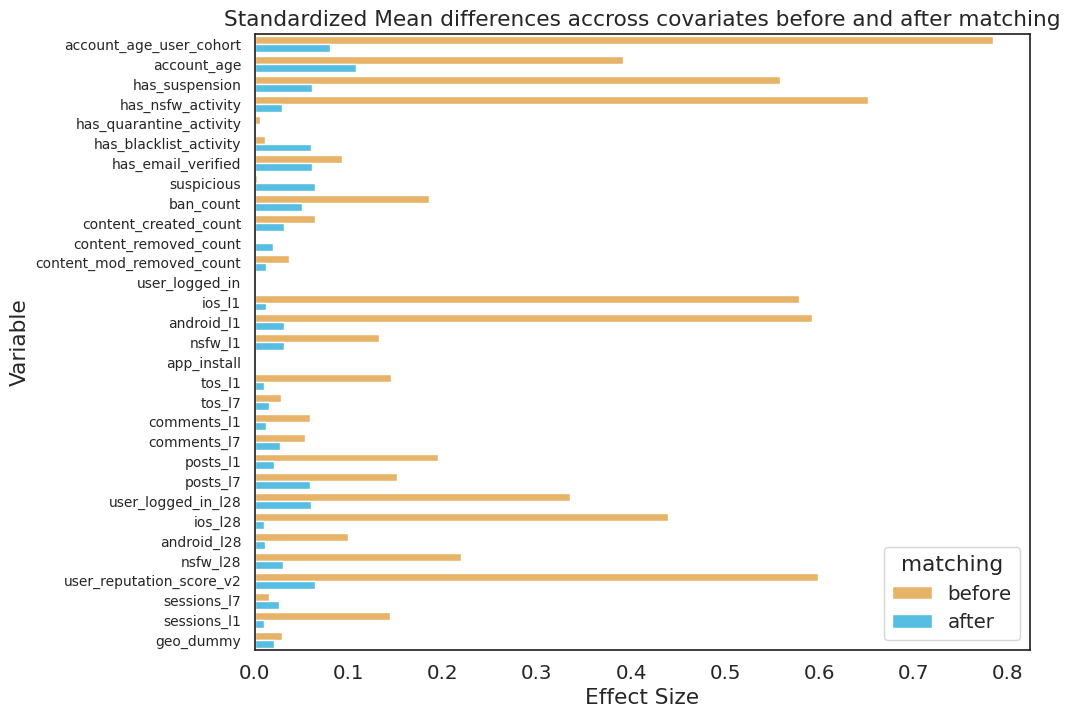

Elapsed time: 0.003574 seconds


In [5]:
import time
# record the start time
start_time = time.perf_counter()

# View Matched IDs Table (Optional)
print("View Matched IDs all users count:")
print(psm.matched_ids.shape)
print("View unique IDs unique users count:")
print(psm.matched_ids.nunique())

# Step 1: Drop duplicate user_ids, keeping the first occurrence
psm.matched_ids = psm.matched_ids.drop_duplicates(subset='user_id', keep='first')

# Step 2: Ensure 'largerclass_0group' has unique values by dropping duplicates
psm.matched_ids = psm.matched_ids.drop_duplicates(subset='largerclass_0group', keep='first')

print("View unique IDs Count after de-dup:")
print(psm.matched_ids.nunique())

# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")


import matplotlib.pyplot as plt

# Generate the plot using psm.effect_size_plot
psm.effect_size_plot(save=True)

# Get the current axis
ax = plt.gca()

# Customize the y-axis font size
ax.tick_params(axis='y', labelsize=10)  # Adjust 'labelsize' to your desired font size

# Save the figure if required
plt.savefig('effect_size_plot.png')

# Show the plot (optional)
plt.show()


## --------------------------------------------------------------------------------------------------------


import time
# record the start time
start_time = time.perf_counter()

# Assume psm.df_matched and psm.matched_ids are already defined DataFrames

# Creating dataframe for PSM matching treatment/control group users
psm.df_matched['group'] = np.where(psm.df_matched['user_id'].isin(psm.matched_ids['user_id']), 'treatment', 'control')
df_psm_group = psm.df_matched[['user_id', 'group']].drop_duplicates()


# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")

In [6]:
def calculate_metrics(df, metric):
    metrics = {}
    # Calculate the overall average of the given metric per user for each group
    avg_metric = df.groupby('group')[metric].mean()

    # Calculate the absolute delta for the period
    avg_metric['absolute_delta'] = avg_metric['treatment'] - avg_metric['control']

    # Calculate the relative delta percentage for the period
    avg_metric['relative_delta'] = (avg_metric['absolute_delta'] / avg_metric['control']) * 100

    # Calculate the p-value for the period
    treatment_data = df[df['group'] == 'treatment'][metric]
    control_data = df[df['group'] == 'control'][metric]
    _, p_value = ttest_ind(
        treatment_data,
        control_data,
        equal_var=True,
        nan_policy='omit',
        random_state = 42
        )

    avg_metric['p_value'] = p_value

    # Calculate means and standard errors
    means = df.groupby('group')[metric].mean()
    std_errors = df.groupby('group')[metric].std() / np.sqrt(df.groupby('group')[metric].count())

    # Calculate confidence intervals for delta percentage
    confidence_level = 0.95
    z_score = norm.ppf((1 + confidence_level) / 2)
    treatment_mean = means['treatment']
    treatment_se = std_errors['treatment']

    # Calculate the confidence interval bounds for the treatment group
    avg_metric['treatment_ci_lower'] = treatment_mean - z_score * treatment_se
    avg_metric['treatment_ci_upper'] = treatment_mean + z_score * treatment_se

    return avg_metric

# 14D

## TOS

Overall Metrics for 'tos':
                            pre          post
aggregation                                  
control             1250.089369  1.654996e+03
treatment           1150.499239  2.830215e+03
absolute_delta       -99.590130  1.175218e+03
relative_delta        -7.966641  7.101033e+01
p_value                0.183285  7.497550e-34
treatment_ci_lower  1046.149135  2.671364e+03
treatment_ci_upper  1254.849343  2.989065e+03


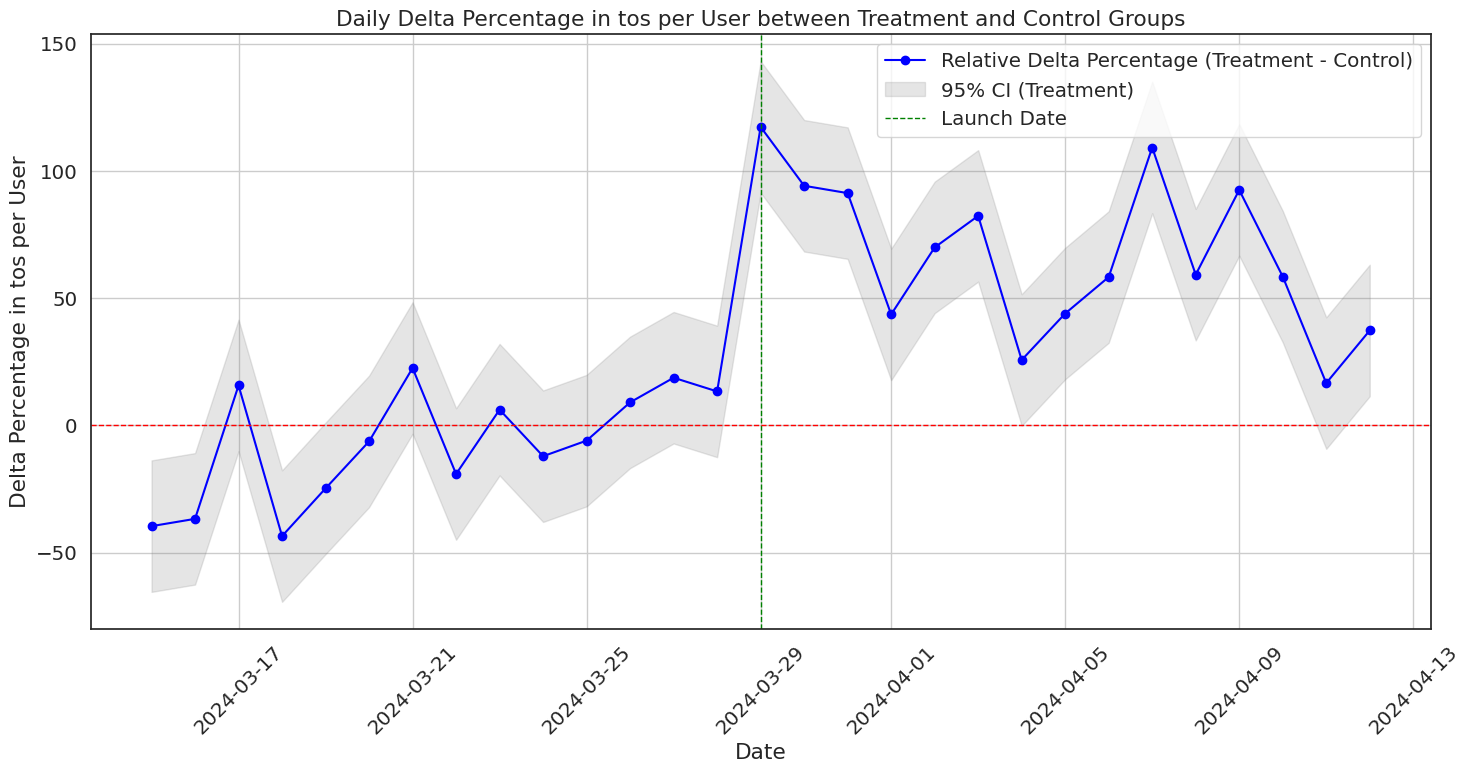

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-03-15,1296.734884,782.774423,-513.960461,-39.634968,25.840285,13.083495
2024-03-16,1203.903876,761.257549,-442.646327,-36.767581,25.840285,13.083495
2024-03-17,940.958140,1088.385435,147.427296,15.667785,25.840285,13.083495
2024-03-18,1554.524031,877.603908,-676.920123,-43.545169,25.840285,13.083495
2024-03-19,1262.877519,949.801066,-313.076454,-24.790722,25.840285,13.083495
2024-03-20,1095.128682,1025.811723,-69.316959,-6.329572,25.840285,13.083495
2024-03-21,1003.054264,1228.843694,225.789431,22.510191,25.840285,13.083495
2024-03-22,1242.612403,1004.653641,-237.958762,-19.149878,25.840285,13.083495
2024-03-23,1091.491473,1158.477798,66.986325,6.137137,25.840285,13.083495


In [7]:
# mapping the TOS data
df1 = tos.copy()

# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)

# Merge all_combinations with df1 to get the time on site data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')

# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')

# Fill NaN values based on column type
df3['tos'] = df3['tos'].astype('float').fillna(0)

# Release more RAM by deleting table no longer used
# del tos

# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
df3['tos'] = winsorize(df3['tos'], limits=[0.01, 0.01])

# Define the separation date
separation_date = pd.to_datetime('2024-03-29')

# Split the data into 'pre' and 'post' periods
pre_df = df3[df3['pt'] < separation_date]
post_df = df3[df3['pt'] >= separation_date]

# Calculate metrics for 'tos' for pre and post periods
pre_metrics = calculate_metrics(pre_df, 'tos')
post_metrics = calculate_metrics(post_df, 'tos')

# Combine metrics into a single DataFrame for 'tos'
overall_metrics = pd.DataFrame({
    'aggregation': pre_metrics.index,
    'pre': pre_metrics.values,
    'post': post_metrics.values
}).set_index('aggregation')

# Print overall metrics for 'tos'
print("Overall Metrics for 'tos':")
print(overall_metrics)

# ---------------- craete a daily aggragate table
# Plotting (for each day if needed for comparison)
daily_avg = df3.groupby(['pt', 'group'])['tos'].mean().unstack()

# Calculate the absolute delta
daily_avg['absolute_delta'] = daily_avg['treatment'] - daily_avg['control']

# Calculate the relative delta percentage
daily_avg['relative_delta'] = (daily_avg['absolute_delta'] / daily_avg['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg.mean()
std_errors = daily_avg.std() / np.sqrt(daily_avg.count())

# Calculate confidence intervals for delta percentage for daily data
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # Define z_score in the global scope
daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# ---------------------------------------
# Plotting
plt.figure(figsize=(15, 8))

# Plot delta percentage
plt.plot(daily_avg.index, daily_avg['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg.index, daily_avg['relative_delta'] - daily_avg['treatment_ci'], daily_avg['relative_delta'] + daily_avg['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

# Add vertical line for launch date
plt.axvline(x=separation_date, color='green', linestyle='--', linewidth=1, label='Launch Date')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in tos per User')
plt.title('Daily Delta Percentage in tos per User between Treatment and Control Groups')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg)

## Comments

In [25]:
sql = '''
with u as (
  SELECT
    *
  FROM
    `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_0329_bets_chat_channels_holdout_exposed_users_step4_v1`
  WHERE
    1=1
    AND user_logged_in = 1
    AND app_install = 1
    AND (ios_l1 > 0
      OR android_l1 > 0)
)

SELECT
  date(pt) pt,
  user_id,
  sum(comments) comments,
  sum(posts) posts
FROM
  `data-prod-165221.all_reddit.user_daily_votes_comments_posts`
WHERE
  date(pt) >= '2024-03-29' - 14 and date(pt) <= '2024-03-29' + 14
  and user_id in (select user_id from u)
group by 1,2
'''

comments_posts = client.query(sql).to_dataframe()

Elapsed time: 126.527115 seconds
Overall Metrics for 'comments':
                          pre          post
aggregation                                
control              0.051384  7.813953e-02
treatment            0.041233  1.204263e-01
absolute_delta      -0.010151  4.228675e-02
relative_delta     -19.755237  5.411698e+01
p_value              0.017982  1.922085e-12
treatment_ci_lower   0.035467  1.109854e-01
treatment_ci_upper   0.046999  1.298671e-01


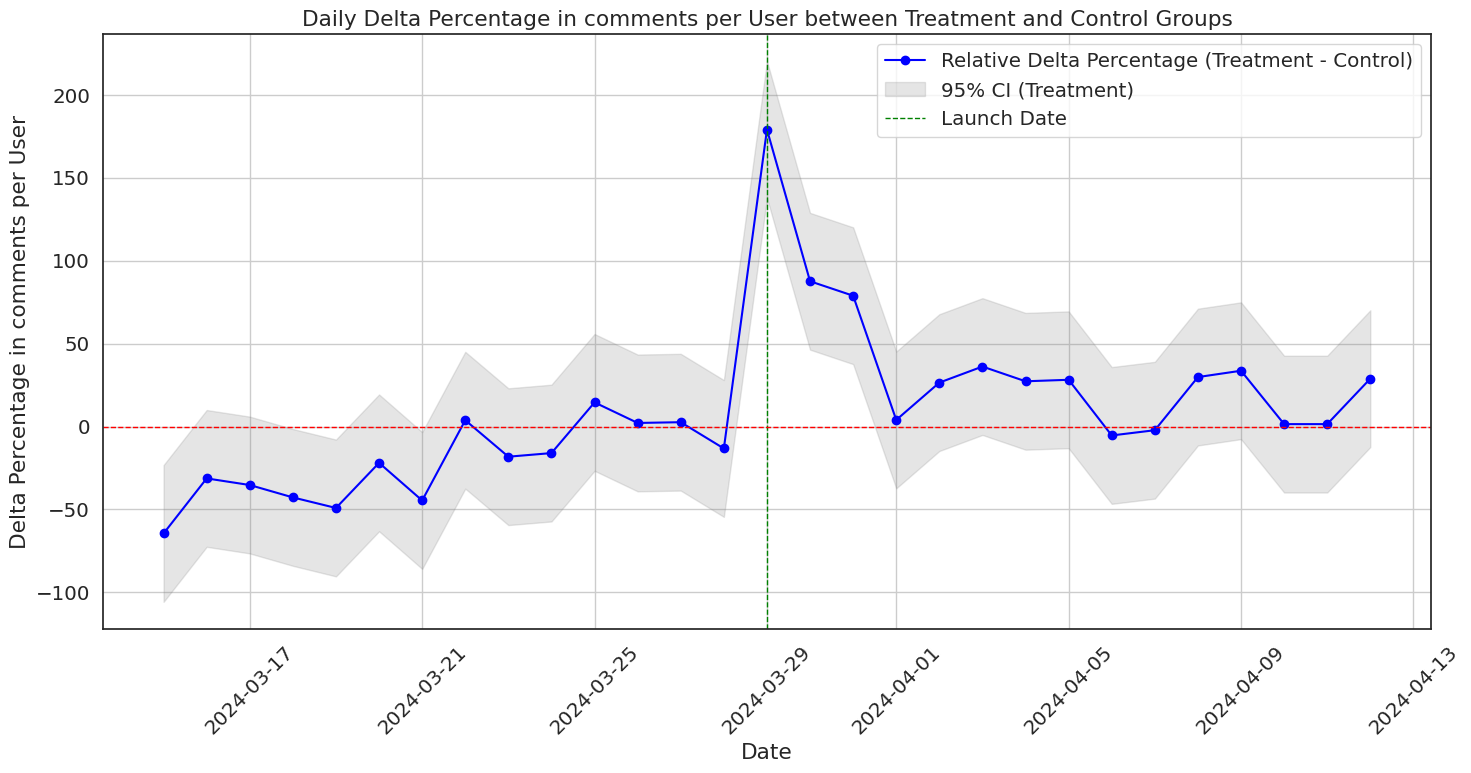

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-03-15,0.044961,0.015986,-0.028975,-64.445397,41.232708,17.34439
2024-03-16,0.046512,0.031972,-0.014540,-31.261101,41.232708,17.34439
2024-03-17,0.035659,0.023091,-0.012568,-35.245965,41.232708,17.34439
2024-03-18,0.046512,0.026643,-0.019869,-42.717584,41.232708,17.34439
2024-03-19,0.041860,0.021314,-0.020546,-49.082297,41.232708,17.34439
2024-03-20,0.034109,0.026643,-0.007466,-21.887615,41.232708,17.34439
2024-03-21,0.048062,0.026643,-0.021419,-44.565404,41.232708,17.34439
2024-03-22,0.049612,0.051510,0.001897,3.824378,41.232708,17.34439
2024-03-23,0.043411,0.035524,-0.007887,-18.167978,41.232708,17.34439


In [26]:
# mapping the comments data
df1 = comments_posts.copy()

# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)

# Merge all_combinations with df1 to get the Comments data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')

# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')

# Fill NaN values based on column type
df3['comments'] = df3['comments'].astype('float').fillna(0)

# Release more RAM by deleting table no longer used
# del comments

# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')


# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")


## --------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
df3['comments'] = winsorize(df3['comments'], limits=[0.025, 0.025])

# Define the separation date
separation_date = pd.to_datetime('2024-03-29')

# Split the data into 'pre' and 'post' periods
pre_df = df3[df3['pt'] < separation_date]
post_df = df3[df3['pt'] >= separation_date]

# Calculate metrics for 'tos' for pre and post periods
pre_metrics = calculate_metrics(pre_df, 'comments')
post_metrics = calculate_metrics(post_df, 'comments')

# Combine metrics into a single DataFrame for 'comments'
overall_metrics = pd.DataFrame({
    'aggregation': pre_metrics.index,
    'pre': pre_metrics.values,
    'post': post_metrics.values
}).set_index('aggregation')

# Print overall metrics for 'comments'
print("Overall Metrics for 'comments':")
print(overall_metrics)

# ---------------- craete a daily aggragate table
# Plotting (for each day if needed for comparison)
daily_avg = df3.groupby(['pt', 'group'])['comments'].mean().unstack()

# Calculate the absolute delta
daily_avg['absolute_delta'] = daily_avg['treatment'] - daily_avg['control']

# Calculate the relative delta percentage
daily_avg['relative_delta'] = (daily_avg['absolute_delta'] / daily_avg['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg.mean()
std_errors = daily_avg.std() / np.sqrt(daily_avg.count())

# Calculate confidence intervals for delta percentage for daily data
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # Define z_score in the global scope
daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# ---------------------------------------
# Plotting
plt.figure(figsize=(15, 8))

# Plot delta percentage
plt.plot(daily_avg.index, daily_avg['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg.index, daily_avg['relative_delta'] - daily_avg['treatment_ci'], daily_avg['relative_delta'] + daily_avg['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

# Add vertical line for launch date
plt.axvline(x=separation_date, color='green', linestyle='--', linewidth=1, label='Launch Date')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in comments per User')
plt.title('Daily Delta Percentage in comments per User between Treatment and Control Groups')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg)

## Post

udpated pre post aggregation

Elapsed time: 182.095170 seconds
Overall Metrics for 'posts':
                          pre          post
aggregation                                
control              0.020377  2.945736e-02
treatment            0.018016  4.428656e-02
absolute_delta      -0.002361  1.482920e-02
relative_delta     -11.585837  5.034122e+01
p_value              0.265358  1.032598e-07
treatment_ci_lower   0.015079  3.989849e-02
treatment_ci_upper   0.020952  4.867463e-02


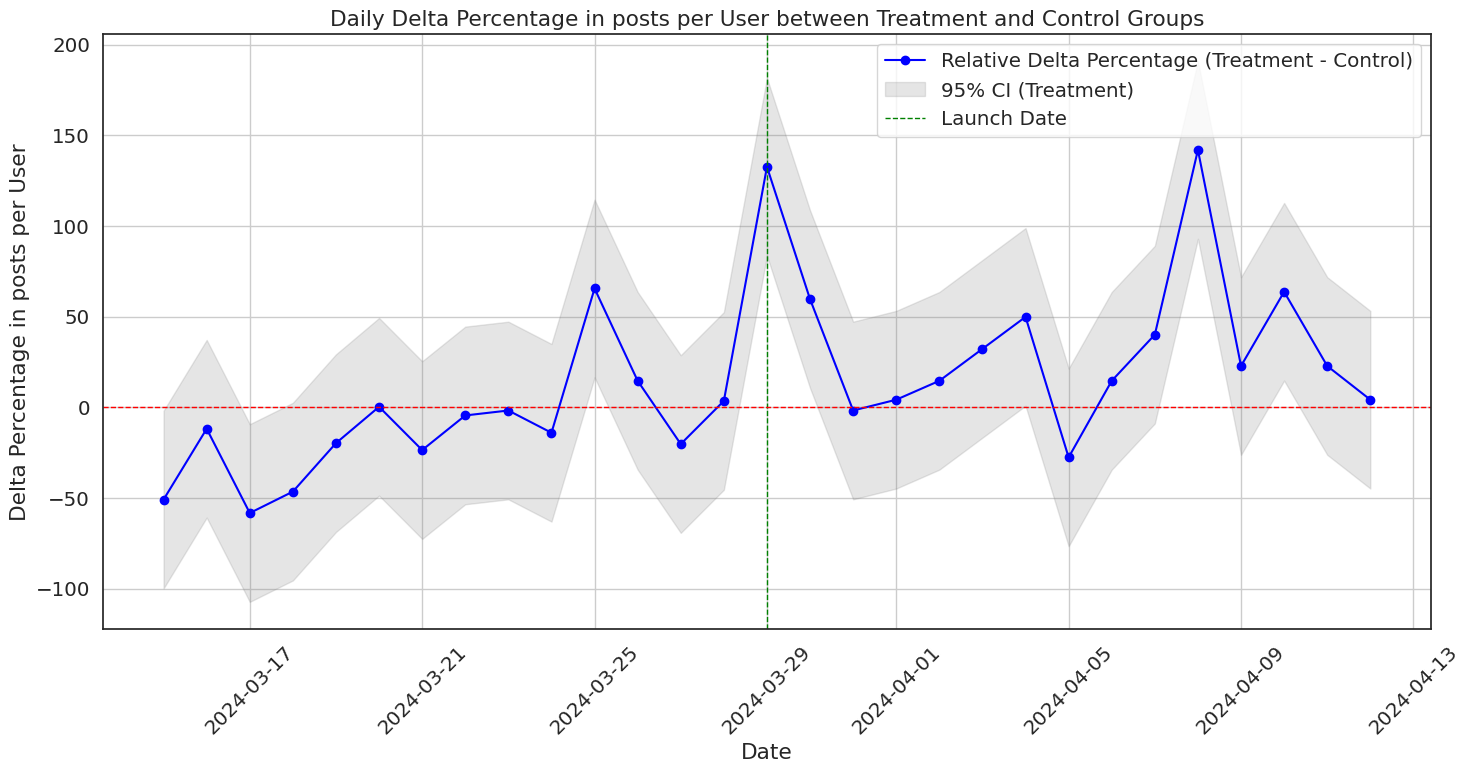

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-03-15,0.010853,0.005329,-0.005524,-50.900787,48.977116,26.382779
2024-03-16,0.020155,0.017762,-0.002393,-11.873207,48.977116,26.382779
2024-03-17,0.017054,0.007105,-0.009949,-58.340061,48.977116,26.382779
2024-03-18,0.023256,0.012433,-0.010822,-46.536412,48.977116,26.382779
2024-03-19,0.015504,0.012433,-0.003070,-19.804618,48.977116,26.382779
2024-03-20,0.012403,0.012433,0.000030,0.244227,48.977116,26.382779
2024-03-21,0.018605,0.014210,-0.004395,-23.623446,48.977116,26.382779
2024-03-22,0.018605,0.017762,-0.000843,-4.529307,48.977116,26.382779
2024-03-23,0.010853,0.010657,-0.000196,-1.801573,48.977116,26.382779


In [27]:
# mapping the posts data
df1 = comments_posts.copy()


# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)


# Merge all_combinations with df1 to get the posts data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')


# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')


# Fill NaN values based on column type
df3['posts'] = df3['posts'].astype('float').fillna(0)


# Release more RAM by deleting table no longer used
# del posts


# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')


# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")


## --------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
df3['posts'] = winsorize(df3['posts'], limits=[0.025, 0.025])

# Define the separation date
separation_date = pd.to_datetime('2024-03-29')

# Split the data into 'pre' and 'post' periods
pre_df = df3[df3['pt'] < separation_date]
post_df = df3[df3['pt'] >= separation_date]

# Calculate metrics for 'tos' for pre and post periods
pre_metrics = calculate_metrics(pre_df, 'posts')
post_metrics = calculate_metrics(post_df, 'posts')

# Combine metrics into a single DataFrame for 'posts'
overall_metrics = pd.DataFrame({
    'aggregation': pre_metrics.index,
    'pre': pre_metrics.values,
    'post': post_metrics.values
}).set_index('aggregation')

# Print overall metrics for 'posts'
print("Overall Metrics for 'posts':")
print(overall_metrics)

# ---------------- craete a daily aggragate table
# Plotting (for each day if needed for comparison)
daily_avg = df3.groupby(['pt', 'group'])['posts'].mean().unstack()

# Calculate the absolute delta
daily_avg['absolute_delta'] = daily_avg['treatment'] - daily_avg['control']

# Calculate the relative delta percentage
daily_avg['relative_delta'] = (daily_avg['absolute_delta'] / daily_avg['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg.mean()
std_errors = daily_avg.std() / np.sqrt(daily_avg.count())

# Calculate confidence intervals for delta percentage for daily data
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # Define z_score in the global scope
daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# ---------------------------------------
# Plotting
plt.figure(figsize=(15, 8))

# Plot delta percentage
plt.plot(daily_avg.index, daily_avg['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg.index, daily_avg['relative_delta'] - daily_avg['treatment_ci'], daily_avg['relative_delta'] + daily_avg['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

# Add vertical line for launch date
plt.axvline(x=separation_date, color='green', linestyle='--', linewidth=1, label='Launch Date')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in posts per User')
plt.title('Daily Delta Percentage in posts per User between Treatment and Control Groups')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg)

In [29]:
sql = '''

select * from `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_0329_chat_holdout_comment_post`
'''

cp_consumed = client.query(sql).to_dataframe()

## comments consumes

Elapsed time: 313.039559 seconds
Overall Metrics for 'comments_consumed':
                         pre          post
aggregation                               
control             0.173976  2.130233e-01
treatment           0.173433  3.327413e-01
absolute_delta     -0.000542  1.197180e-01
relative_delta     -0.311824  5.619950e+01
p_value             0.960184  2.549796e-21
treatment_ci_lower  0.158067  3.128118e-01
treatment_ci_upper  0.188799  3.526708e-01


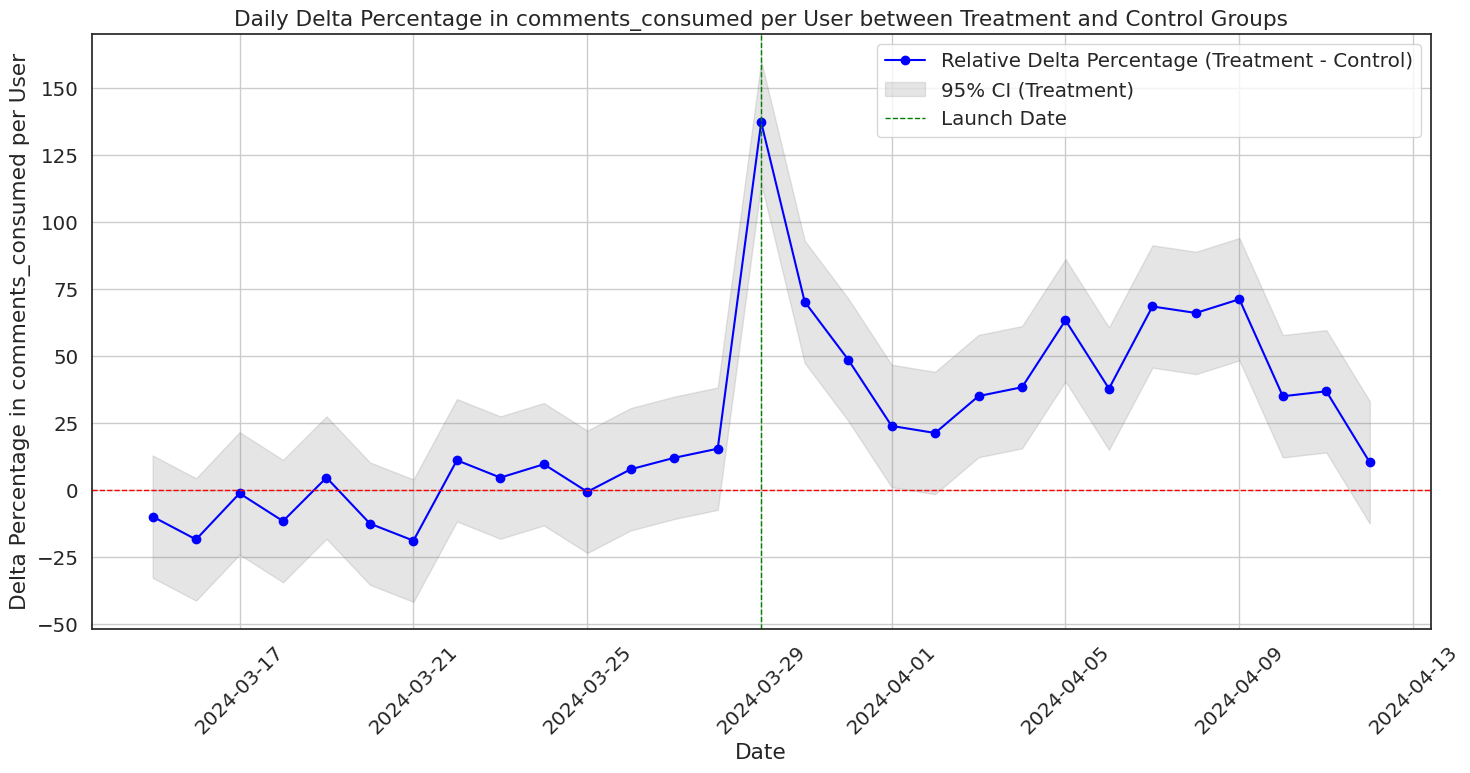

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-03-15,0.159690,0.143872,-0.015818,-9.905327,22.842215,10.519712
2024-03-16,0.182946,0.149201,-0.033745,-18.445374,22.842215,10.519712
2024-03-17,0.134884,0.133215,-0.001669,-1.237214,22.842215,10.519712
2024-03-18,0.196899,0.174067,-0.022832,-11.595642,22.842215,10.519712
2024-03-19,0.161240,0.168739,0.007499,4.650567,22.842215,10.519712
2024-03-20,0.144186,0.126110,-0.018076,-12.536527,22.842215,10.519712
2024-03-21,0.175194,0.142096,-0.033098,-18.892155,22.842215,10.519712
2024-03-22,0.155039,0.172291,0.017253,11.127886,22.842215,10.519712
2024-03-23,0.161240,0.168739,0.007499,4.650567,22.842215,10.519712


In [30]:
# mapping the comments_consumed data
df1 = cp_consumed.copy()

# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)

# Merge all_combinations with df1 to get the comments_consumed data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')

# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')

# Fill NaN values based on column type
df3['comments_consumed'] = df3['comments_consumed'].astype('float').fillna(0)

# Release more RAM by deleting table no longer used
# del comments_consumed

# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')

# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")

## --------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
df3['comments_consumed'] = winsorize(df3['comments_consumed'], limits=[0.025, 0.025])

# Define the separation date
separation_date = pd.to_datetime('2024-03-29')

# Split the data into 'pre' and 'post' periods
pre_df = df3[df3['pt'] < separation_date]
post_df = df3[df3['pt'] >= separation_date]

# Calculate metrics for 'tos' for pre and post periods
pre_metrics = calculate_metrics(pre_df, 'comments_consumed')
post_metrics = calculate_metrics(post_df, 'comments_consumed')

# Combine metrics into a single DataFrame for 'comments_consumed'
overall_metrics = pd.DataFrame({
    'aggregation': pre_metrics.index,
    'pre': pre_metrics.values,
    'post': post_metrics.values
}).set_index('aggregation')

# Print overall metrics for 'comments_consumed'
print("Overall Metrics for 'comments_consumed':")
print(overall_metrics)

# ---------------- craete a daily aggragate table
# Plotting (for each day if needed for comparison)
daily_avg = df3.groupby(['pt', 'group'])['comments_consumed'].mean().unstack()

# Calculate the absolute delta
daily_avg['absolute_delta'] = daily_avg['treatment'] - daily_avg['control']

# Calculate the relative delta percentage
daily_avg['relative_delta'] = (daily_avg['absolute_delta'] / daily_avg['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg.mean()
std_errors = daily_avg.std() / np.sqrt(daily_avg.count())

# Calculate confidence intervals for delta percentage for daily data
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # Define z_score in the global scope
daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# ---------------------------------------
# Plotting
plt.figure(figsize=(15, 8))

# Plot delta percentage
plt.plot(daily_avg.index, daily_avg['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg.index, daily_avg['relative_delta'] - daily_avg['treatment_ci'], daily_avg['relative_delta'] + daily_avg['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

# Add vertical line for launch date
plt.axvline(x=separation_date, color='green', linestyle='--', linewidth=1, label='Launch Date')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in comments_consumed per User')
plt.title('Daily Delta Percentage in comments_consumed per User between Treatment and Control Groups')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg)


## posts consumes

Elapsed time: 388.257691 seconds
Overall Metrics for 'posts_consumed':
                          pre          post
aggregation                                
control             63.909967  8.393003e+01
treatment           61.240548  1.178679e+02
absolute_delta      -2.669419  3.393782e+01
relative_delta      -4.176843  4.043586e+01
p_value              0.357780  2.689965e-23
treatment_ci_lower  57.027441  1.125359e+02
treatment_ci_upper  65.453655  1.231998e+02


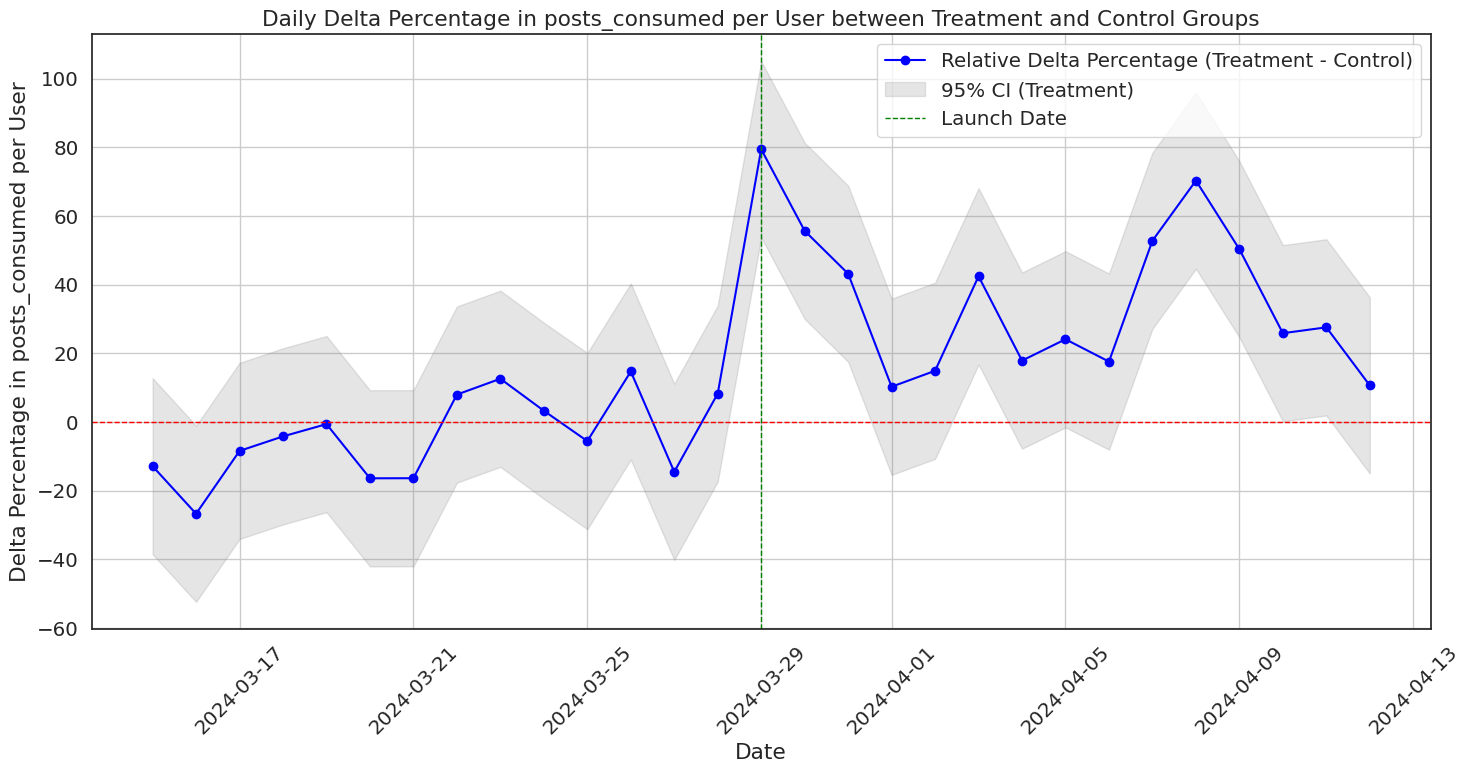

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-03-15,54.893023,47.818828,-7.074196,-12.887240,25.655309,15.492175
2024-03-16,60.986047,44.682060,-16.303986,-26.733961,25.655309,15.492175
2024-03-17,54.522481,49.927176,-4.595305,-8.428275,25.655309,15.492175
2024-03-18,64.982946,62.253996,-2.728949,-4.199485,25.655309,15.492175
2024-03-19,59.001550,58.635879,-0.365671,-0.619765,25.655309,15.492175
2024-03-20,56.674419,47.374778,-9.299641,-16.408886,25.655309,15.492175
2024-03-21,58.886822,49.239787,-9.647035,-16.382332,25.655309,15.492175
2024-03-22,59.279070,64.008881,4.729811,7.978889,25.655309,15.492175
2024-03-23,51.855814,58.383659,6.527845,12.588453,25.655309,15.492175


In [32]:
# mapping the posts_consumed data
df1 = cp_consumed.copy()


# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)


# Merge all_combinations with df1 to get the posts_consumed data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')


# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')


# Fill NaN values based on column type
df3['posts_consumed'] = df3['posts_consumed'].astype('float').fillna(0)


# Release more RAM by deleting table no longer used
# del posts_consumed


# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')


# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")


## --------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
df3['posts_consumed'] = winsorize(df3['posts_consumed'], limits=[0.025, 0.025])

# Define the separation date
separation_date = pd.to_datetime('2024-03-29')

# Split the data into 'pre' and 'post' periods
pre_df = df3[df3['pt'] < separation_date]
post_df = df3[df3['pt'] >= separation_date]

# Calculate metrics for 'tos' for pre and post periods
pre_metrics = calculate_metrics(pre_df, 'posts_consumed')
post_metrics = calculate_metrics(post_df, 'posts_consumed')

# Combine metrics into a single DataFrame for 'posts_consumed'
overall_metrics = pd.DataFrame({
    'aggregation': pre_metrics.index,
    'pre': pre_metrics.values,
    'post': post_metrics.values
}).set_index('aggregation')

# Print overall metrics for 'posts_consumed'
print("Overall Metrics for 'posts_consumed':")
print(overall_metrics)

# ---------------- craete a daily aggragate table
# Plotting (for each day if needed for comparison)
daily_avg = df3.groupby(['pt', 'group'])['posts_consumed'].mean().unstack()

# Calculate the absolute delta
daily_avg['absolute_delta'] = daily_avg['treatment'] - daily_avg['control']

# Calculate the relative delta percentage
daily_avg['relative_delta'] = (daily_avg['absolute_delta'] / daily_avg['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg.mean()
std_errors = daily_avg.std() / np.sqrt(daily_avg.count())

# Calculate confidence intervals for delta percentage for daily data
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # Define z_score in the global scope
daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# ---------------------------------------
# Plotting
plt.figure(figsize=(15, 8))

# Plot delta percentage
plt.plot(daily_avg.index, daily_avg['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg.index, daily_avg['relative_delta'] - daily_avg['treatment_ci'], daily_avg['relative_delta'] + daily_avg['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

# Add vertical line for launch date
plt.axvline(x=separation_date, color='green', linestyle='--', linewidth=1, label='Launch Date')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in posts_consumed per User')
plt.title('Daily Delta Percentage in posts_consumed per User between Treatment and Control Groups')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg)


# 60D

## ToS (28D)

In [35]:
sql = '''
select * from `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_0329_bets_chat_channels_holdout_tos_prepost28`
'''

tos28 = client.query(sql).to_dataframe()

Overall Metrics for 'tos':
                           pre          post
aggregation                                 
control             893.097896  1.133567e+03
treatment           811.226338  1.714671e+03
absolute_delta      -81.871557  5.811047e+02
relative_delta       -9.167143  5.126339e+01
p_value               0.014114  1.084658e-43
treatment_ci_lower  764.308929  1.647599e+03
treatment_ci_upper  858.143748  1.781744e+03


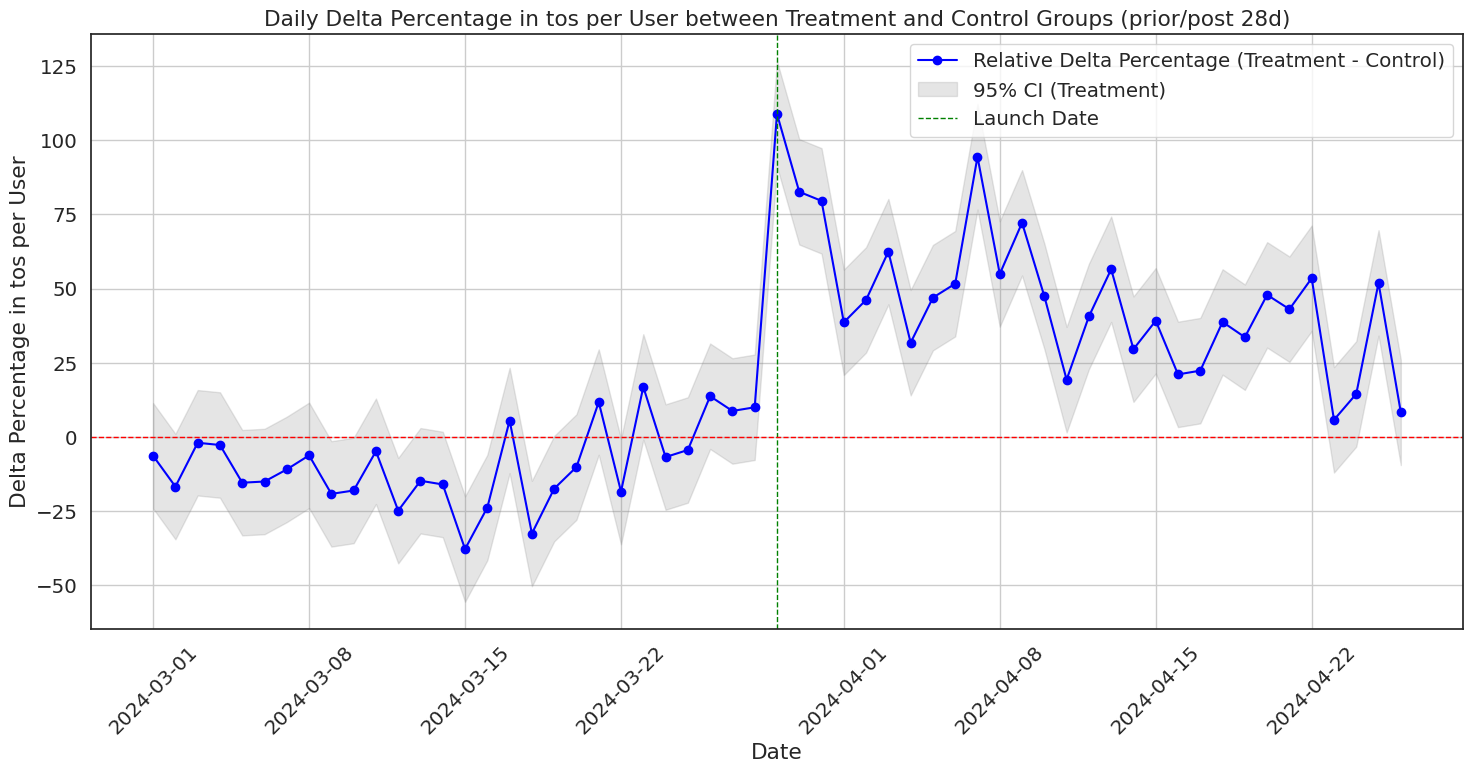

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-03-01,865.238760,810.454707,-54.784053,-6.331669,17.76464,8.934562
2024-03-02,759.762791,632.827709,-126.935082,-16.707199,17.76464,8.934562
2024-03-03,704.700775,691.060391,-13.640384,-1.935628,17.76464,8.934562
2024-03-04,809.702326,787.909414,-21.792912,-2.691472,17.76464,8.934562
2024-03-05,794.037209,671.770870,-122.266339,-15.398062,17.76464,8.934562
2024-03-06,833.824806,708.802842,-125.021964,-14.993793,17.76464,8.934562
2024-03-07,802.348837,714.808171,-87.540667,-10.910549,17.76464,8.934562
2024-03-08,749.899225,703.555950,-46.343275,-6.179934,17.76464,8.934562
2024-03-09,857.854264,693.474245,-164.380018,-19.161765,17.76464,8.934562


In [36]:
# mapping the TOS data
df1 = tos28.copy()

# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)

# Merge all_combinations with df1 to get the time on site data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')

# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')

# Fill NaN values based on column type
df3['tos'] = df3['tos'].astype('float').fillna(0)

# Release more RAM by deleting table no longer used
# del tos

# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
df3['tos'] = winsorize(df3['tos'], limits=[0.025, 0.025])

# Define the separation date
separation_date = pd.to_datetime('2024-03-29')

# Split the data into 'pre' and 'post' periods
pre_df = df3[df3['pt'] < separation_date]
post_df = df3[df3['pt'] >= separation_date]

# Calculate metrics for 'tos' for pre and post periods
pre_metrics = calculate_metrics(pre_df, 'tos')
post_metrics = calculate_metrics(post_df, 'tos')

# Combine metrics into a single DataFrame for 'tos'
overall_metrics = pd.DataFrame({
    'aggregation': pre_metrics.index,
    'pre': pre_metrics.values,
    'post': post_metrics.values
}).set_index('aggregation')

# Print overall metrics for 'tos'
print("Overall Metrics for 'tos':")
print(overall_metrics)

# ---------------- craete a daily aggragate table
# Plotting (for each day if needed for comparison)
daily_avg = df3.groupby(['pt', 'group'])['tos'].mean().unstack()

# Calculate the absolute delta
daily_avg['absolute_delta'] = daily_avg['treatment'] - daily_avg['control']

# Calculate the relative delta percentage
daily_avg['relative_delta'] = (daily_avg['absolute_delta'] / daily_avg['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg.mean()
std_errors = daily_avg.std() / np.sqrt(daily_avg.count())

# Calculate confidence intervals for delta percentage for daily data
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # Define z_score in the global scope
daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# ---------------------------------------
# Plotting
plt.figure(figsize=(15, 8))

# Plot delta percentage
plt.plot(daily_avg.index, daily_avg['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg.index, daily_avg['relative_delta'] - daily_avg['treatment_ci'], daily_avg['relative_delta'] + daily_avg['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

# Add vertical line for launch date
plt.axvline(x=separation_date, color='green', linestyle='--', linewidth=1, label='Launch Date')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in tos per User')
plt.title('Daily Delta Percentage in tos per User between Treatment and Control Groups (prior/post 28d)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg)

## ToS (60D)

In [16]:
sql = '''
select * from `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_0329_bets_chat_channels_holdout_tos_prepost60`
'''

tos60 = client.query(sql).to_dataframe()

Overall Metrics for 'tos':
                           pre          post
aggregation                                 
control             748.029225  8.965319e+02
treatment           679.489905  1.270838e+03
absolute_delta      -68.539320  3.743059e+02
relative_delta       -9.162653  4.175043e+01
p_value               0.000370  1.092233e-56
treatment_ci_lower  652.277068  1.233478e+03
treatment_ci_upper  706.702742  1.308198e+03


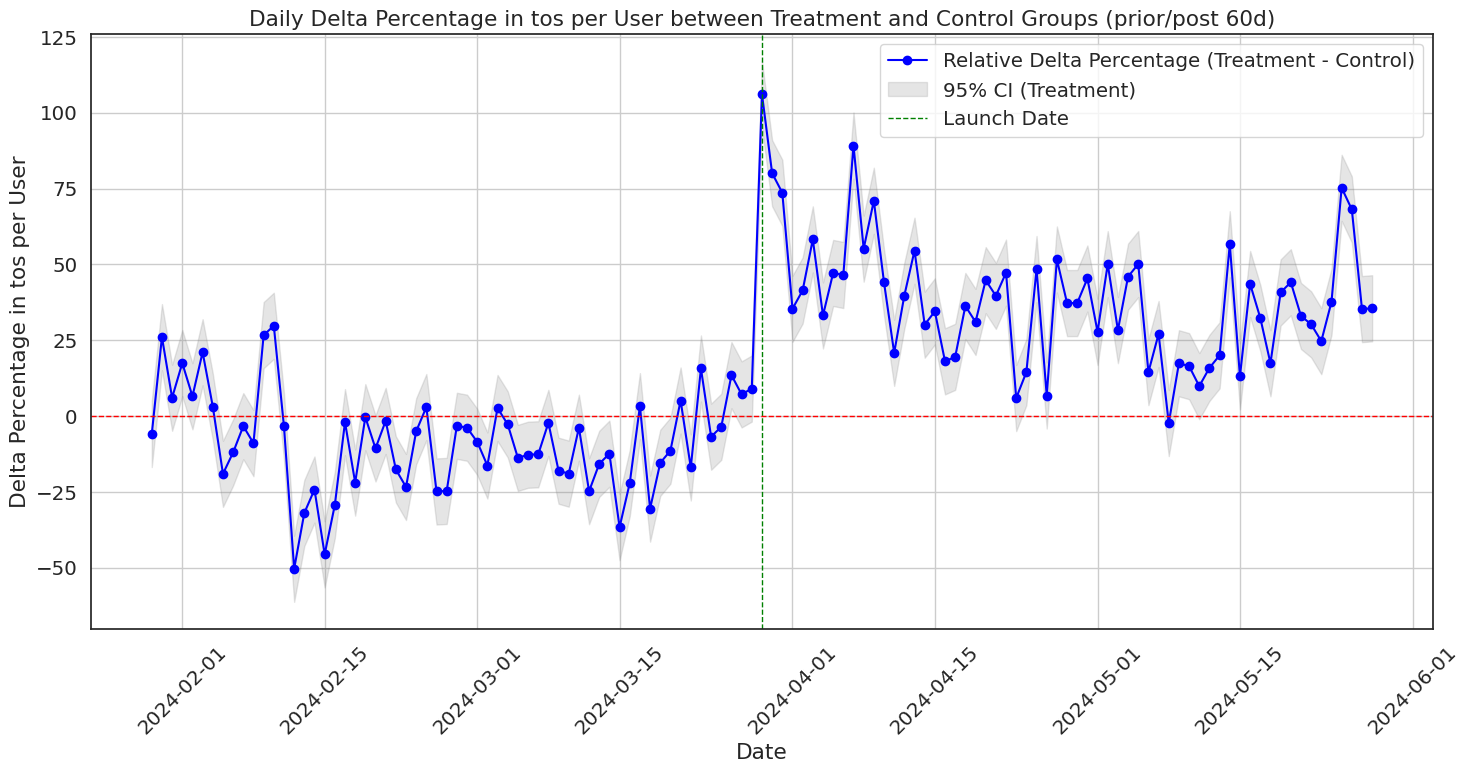

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-01-29,614.621705,578.420959,-36.200746,-5.889923,10.89832,5.675076
2024-01-30,484.519380,610.717584,126.198205,26.046059,10.89832,5.675076
2024-01-31,616.105426,653.483126,37.377700,6.066770,10.89832,5.675076
2024-02-01,592.372093,695.925400,103.553307,17.481125,10.89832,5.675076
2024-02-02,621.489922,662.120782,40.630859,6.537654,10.89832,5.675076
2024-02-03,527.379845,638.472469,111.092624,21.065011,10.89832,5.675076
2024-02-04,591.156589,609.849023,18.692434,3.162011,10.89832,5.675076
2024-02-05,744.696124,603.015986,-141.680138,-19.025228,10.89832,5.675076
2024-02-06,652.820155,574.683837,-78.136318,-11.969042,10.89832,5.675076


In [34]:
# mapping the TOS data
df1 = tos60.copy()

# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)

# Merge all_combinations with df1 to get the time on site data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')

# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')

# Fill NaN values based on column type
df3['tos'] = df3['tos'].astype('float').fillna(0)

# Release more RAM by deleting table no longer used
# del tos

# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
df3['tos'] = winsorize(df3['tos'], limits=[0.025, 0.025])

# Define the separation date
separation_date = pd.to_datetime('2024-03-29')

# Split the data into 'pre' and 'post' periods
pre_df = df3[df3['pt'] < separation_date]
post_df = df3[df3['pt'] >= separation_date]

# Calculate metrics for 'tos' for pre and post periods
pre_metrics = calculate_metrics(pre_df, 'tos')
post_metrics = calculate_metrics(post_df, 'tos')

# Combine metrics into a single DataFrame for 'tos'
overall_metrics = pd.DataFrame({
    'aggregation': pre_metrics.index,
    'pre': pre_metrics.values,
    'post': post_metrics.values
}).set_index('aggregation')

# Print overall metrics for 'tos'
print("Overall Metrics for 'tos':")
print(overall_metrics)

# ---------------- craete a daily aggragate table
# Plotting (for each day if needed for comparison)
daily_avg = df3.groupby(['pt', 'group'])['tos'].mean().unstack()

# Calculate the absolute delta
daily_avg['absolute_delta'] = daily_avg['treatment'] - daily_avg['control']

# Calculate the relative delta percentage
daily_avg['relative_delta'] = (daily_avg['absolute_delta'] / daily_avg['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg.mean()
std_errors = daily_avg.std() / np.sqrt(daily_avg.count())

# Calculate confidence intervals for delta percentage for daily data
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # Define z_score in the global scope
daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# ---------------------------------------
# Plotting
plt.figure(figsize=(15, 8))

# Plot delta percentage
plt.plot(daily_avg.index, daily_avg['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg.index, daily_avg['relative_delta'] - daily_avg['treatment_ci'], daily_avg['relative_delta'] + daily_avg['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

# Add vertical line for launch date
plt.axvline(x=separation_date, color='green', linestyle='--', linewidth=1, label='Launch Date')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in tos per User')
plt.title('Daily Delta Percentage in tos per User between Treatment and Control Groups (prior/post 60d)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg)

## comments

In [46]:
sql = '''
with u as (
  SELECT
    *
  FROM
    `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_0329_bets_chat_channels_holdout_exposed_users_step4_v1`
  WHERE
    1=1
    AND user_logged_in = 1
    AND app_install = 1
    AND (ios_l1 > 0
      OR android_l1 > 0)
)

SELECT
  date(pt) pt,
  user_id,
  sum(comments) comments,
  sum(posts) posts
FROM
  `data-prod-165221.all_reddit.user_daily_votes_comments_posts`
WHERE
  date(pt) >= '2024-03-29' - 60 and date(pt) <= '2024-03-29' + 60
  and user_id in (select user_id from u)
group by 1,2
'''

comments_posts60 = client.query(sql).to_dataframe()

Elapsed time: 632.781386 seconds
Overall Metrics for 'comments':
                             pre       post
aggregation                                
control             2.565891e-02   0.031745
treatment           1.628182e-02   0.035873
absolute_delta     -9.377091e-03   0.004129
relative_delta     -3.654516e+01  13.005502
p_value             2.622254e-18   0.001938
treatment_ci_lower  1.493220e-02   0.033906
treatment_ci_upper  1.763144e-02   0.037840


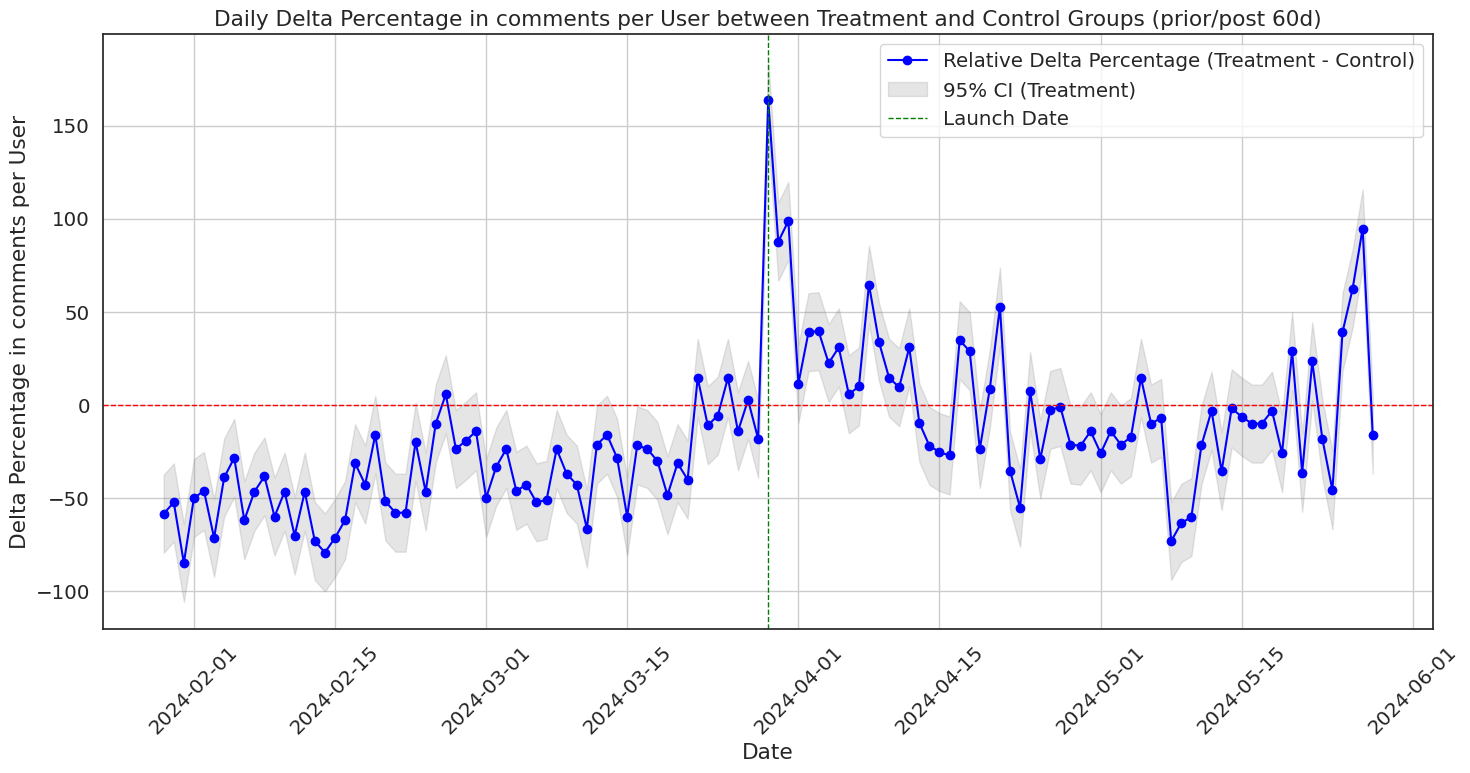

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-01-29,0.017054,0.007105,-0.009949,-58.340061,20.930829,7.553567
2024-01-30,0.018605,0.008881,-0.009724,-52.264654,20.930829,7.553567
2024-01-31,0.023256,0.003552,-0.019703,-84.724689,20.930829,7.553567
2024-02-01,0.024806,0.012433,-0.012373,-49.877886,20.930829,7.553567
2024-02-02,0.026357,0.014210,-0.012147,-46.087138,20.930829,7.553567
2024-02-03,0.018605,0.005329,-0.013276,-71.358792,20.930829,7.553567
2024-02-04,0.023256,0.014210,-0.009046,-38.898757,20.930829,7.553567
2024-02-05,0.024806,0.017762,-0.007044,-28.396980,20.930829,7.553567
2024-02-06,0.027907,0.010657,-0.017250,-61.811723,20.930829,7.553567


In [47]:
# mapping the comments data
df1 = comments_posts60.copy()

# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)

# Merge all_combinations with df1 to get the Comments data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')

# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')

# Fill NaN values based on column type
df3['comments'] = df3['comments'].astype('float').fillna(0)

# Release more RAM by deleting table no longer used
# del comments

# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')


# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")


## --------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
df3['comments'] = winsorize(df3['comments'], limits=[0.025, 0.025])

# Define the separation date
separation_date = pd.to_datetime('2024-03-29')

# Split the data into 'pre' and 'post' periods
pre_df = df3[df3['pt'] < separation_date]
post_df = df3[df3['pt'] >= separation_date]

# Calculate metrics for 'tos' for pre and post periods
pre_metrics = calculate_metrics(pre_df, 'comments')
post_metrics = calculate_metrics(post_df, 'comments')

# Combine metrics into a single DataFrame for 'comments'
overall_metrics = pd.DataFrame({
    'aggregation': pre_metrics.index,
    'pre': pre_metrics.values,
    'post': post_metrics.values
}).set_index('aggregation')

# Print overall metrics for 'comments'
print("Overall Metrics for 'comments':")
print(overall_metrics)

# ---------------- craete a daily aggragate table
# Plotting (for each day if needed for comparison)
daily_avg = df3.groupby(['pt', 'group'])['comments'].mean().unstack()

# Calculate the absolute delta
daily_avg['absolute_delta'] = daily_avg['treatment'] - daily_avg['control']

# Calculate the relative delta percentage
daily_avg['relative_delta'] = (daily_avg['absolute_delta'] / daily_avg['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg.mean()
std_errors = daily_avg.std() / np.sqrt(daily_avg.count())

# Calculate confidence intervals for delta percentage for daily data
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # Define z_score in the global scope
daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# ---------------------------------------
# Plotting
plt.figure(figsize=(15, 8))

# Plot delta percentage
plt.plot(daily_avg.index, daily_avg['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg.index, daily_avg['relative_delta'] - daily_avg['treatment_ci'], daily_avg['relative_delta'] + daily_avg['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

# Add vertical line for launch date
plt.axvline(x=separation_date, color='green', linestyle='--', linewidth=1, label='Launch Date')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in comments per User')
plt.title('Daily Delta Percentage in comments per User between Treatment and Control Groups (prior/post 60d)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg)

## posts

Elapsed time: 634.034830 seconds
Overall Metrics for 'posts (prior/post 60d)':
                    pre  post
aggregation                  
control             0.0   0.0
treatment           0.0   0.0
absolute_delta      0.0   0.0
relative_delta      NaN   NaN
p_value             NaN   NaN
treatment_ci_lower  0.0   0.0
treatment_ci_upper  0.0   0.0


<ipython-input-6-c1f03d4df891>:10: RuntimeWarning: invalid value encountered in scalar divide
  avg_metric['relative_delta'] = (avg_metric['absolute_delta'] / avg_metric['control']) * 100
<ipython-input-6-c1f03d4df891>:10: RuntimeWarning: invalid value encountered in scalar divide
  avg_metric['relative_delta'] = (avg_metric['absolute_delta'] / avg_metric['control']) * 100
<ipython-input-48-ecced7d9a2d8>:86: RuntimeWarning: invalid value encountered in scalar divide
  daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
<ipython-input-48-ecced7d9a2d8>:87: RuntimeWarning: invalid value encountered in scalar divide
  daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100


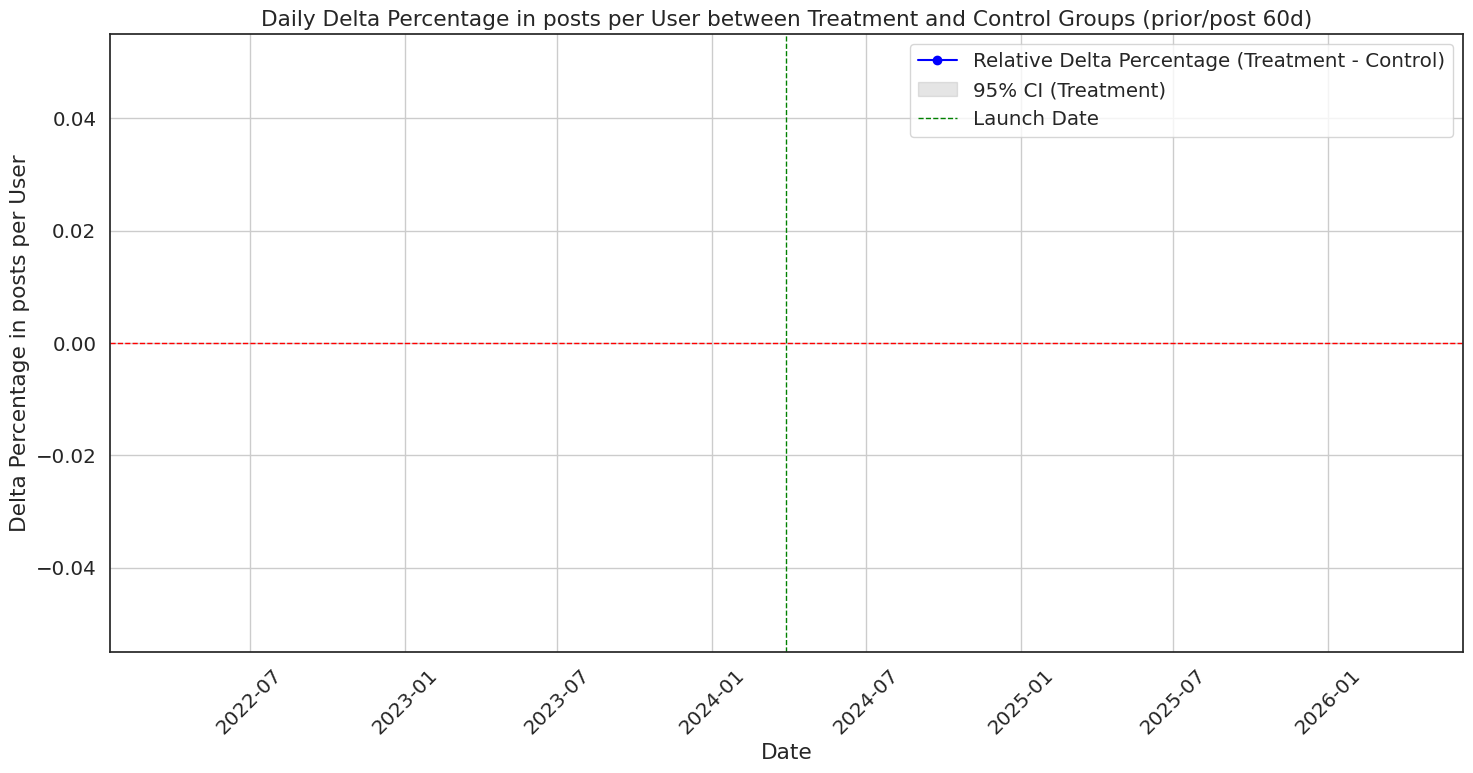

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-01-29,0.0,0.0,0.0,NaN,NaN,NaN
2024-01-30,0.0,0.0,0.0,NaN,NaN,NaN
2024-01-31,0.0,0.0,0.0,NaN,NaN,NaN
2024-02-01,0.0,0.0,0.0,NaN,NaN,NaN
2024-02-02,0.0,0.0,0.0,NaN,NaN,NaN
2024-02-03,0.0,0.0,0.0,NaN,NaN,NaN
2024-02-04,0.0,0.0,0.0,NaN,NaN,NaN
2024-02-05,0.0,0.0,0.0,NaN,NaN,NaN
2024-02-06,0.0,0.0,0.0,NaN,NaN,NaN


In [48]:
# mapping the posts data
df1 = comments_posts60.copy()


# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)


# Merge all_combinations with df1 to get the posts data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')


# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')


# Fill NaN values based on column type
df3['posts'] = df3['posts'].astype('float').fillna(0)


# Release more RAM by deleting table no longer used
# del posts


# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')


# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")


## --------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
df3['posts'] = winsorize(df3['posts'], limits=[0.025, 0.025])

# Define the separation date
separation_date = pd.to_datetime('2024-03-29')

# Split the data into 'pre' and 'post' periods
pre_df = df3[df3['pt'] < separation_date]
post_df = df3[df3['pt'] >= separation_date]

# Calculate metrics for 'tos' for pre and post periods
pre_metrics = calculate_metrics(pre_df, 'posts')
post_metrics = calculate_metrics(post_df, 'posts')

# Combine metrics into a single DataFrame for 'posts'
overall_metrics = pd.DataFrame({
    'aggregation': pre_metrics.index,
    'pre': pre_metrics.values,
    'post': post_metrics.values
}).set_index('aggregation')

# Print overall metrics for 'posts'
print("Overall Metrics for 'posts (prior/post 60d)':")
print(overall_metrics)

# ---------------- craete a daily aggragate table
# Plotting (for each day if needed for comparison)
daily_avg = df3.groupby(['pt', 'group'])['posts'].mean().unstack()

# Calculate the absolute delta
daily_avg['absolute_delta'] = daily_avg['treatment'] - daily_avg['control']

# Calculate the relative delta percentage
daily_avg['relative_delta'] = (daily_avg['absolute_delta'] / daily_avg['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg.mean()
std_errors = daily_avg.std() / np.sqrt(daily_avg.count())

# Calculate confidence intervals for delta percentage for daily data
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # Define z_score in the global scope
daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# ---------------------------------------
# Plotting
plt.figure(figsize=(15, 8))

# Plot delta percentage
plt.plot(daily_avg.index, daily_avg['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg.index, daily_avg['relative_delta'] - daily_avg['treatment_ci'], daily_avg['relative_delta'] + daily_avg['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

# Add vertical line for launch date
plt.axvline(x=separation_date, color='green', linestyle='--', linewidth=1, label='Launch Date')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in posts per User')
plt.title('Daily Delta Percentage in posts per User between Treatment and Control Groups (prior/post 60d)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg)

## comments consumes

In [40]:
sql = '''

select * from `data-prod-165221.ds_v2_gold_tables.wjfeng_tmp_0329_chat_holdout_comment_post_60d`
'''

cp_consumed60 = client.query(sql).to_dataframe()

Elapsed time: 583.781202 seconds
Overall Metrics for 'comments_consumed':
                         pre          post
aggregation                               
control             0.131189  1.011051e-01
treatment           0.122114  1.385057e-01
absolute_delta     -0.009075  3.740066e-02
relative_delta     -6.917485  3.699188e+01
p_value             0.024588  5.997394e-18
treatment_ci_lower  0.116453  1.318231e-01
treatment_ci_upper  0.127774  1.451883e-01


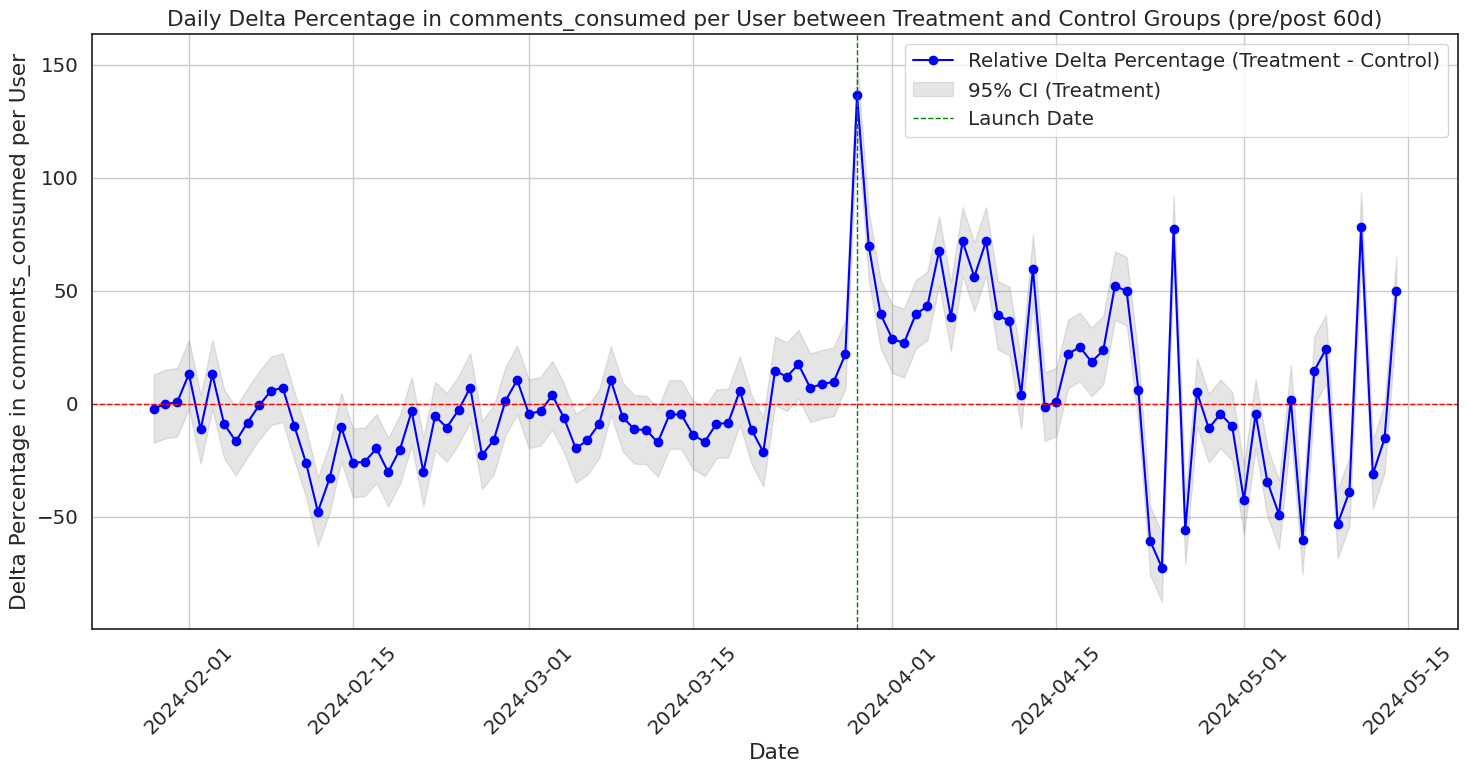

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-01-29,0.127132,0.124334,-0.002798,-2.200754,15.166048,9.227003
2024-01-30,0.120930,0.120782,-0.000149,-0.122968,15.166048,9.227003
2024-01-31,0.127132,0.127886,0.000755,0.593510,15.166048,9.227003
2024-02-01,0.127132,0.143872,0.016740,13.167699,15.166048,9.227003
2024-02-02,0.116279,0.103020,-0.013260,-11.403197,15.166048,9.227003
2024-02-03,0.108527,0.122558,0.014031,12.928191,15.166048,9.227003
2024-02-04,0.120930,0.110124,-0.010806,-8.935647,15.166048,9.227003
2024-02-05,0.136434,0.113677,-0.022757,-16.680123,15.166048,9.227003
2024-02-06,0.108527,0.099467,-0.009060,-8.348135,15.166048,9.227003


In [44]:
# mapping the comments_consumed data
df1 = cp_consumed60.copy()

# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)

# Merge all_combinations with df1 to get the comments_consumed data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')

# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')

# Fill NaN values based on column type
df3['comments_consumed'] = df3['comments_consumed'].astype('float').fillna(0)

# Release more RAM by deleting table no longer used
# del comments_consumed

# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')

# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")

## --------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
df3['comments_consumed'] = winsorize(df3['comments_consumed'], limits=[0.025, 0.025])

# Define the separation date
separation_date = pd.to_datetime('2024-03-29')

# Split the data into 'pre' and 'post' periods
pre_df = df3[df3['pt'] < separation_date]
post_df = df3[df3['pt'] >= separation_date]

# Calculate metrics for 'tos' for pre and post periods
pre_metrics = calculate_metrics(pre_df, 'comments_consumed')
post_metrics = calculate_metrics(post_df, 'comments_consumed')

# Combine metrics into a single DataFrame for 'comments_consumed'
overall_metrics = pd.DataFrame({
    'aggregation': pre_metrics.index,
    'pre': pre_metrics.values,
    'post': post_metrics.values
}).set_index('aggregation')

# Print overall metrics for 'comments_consumed'
print("Overall Metrics for 'comments_consumed':")
print(overall_metrics)

# ---------------- craete a daily aggragate table
# Plotting (for each day if needed for comparison)
daily_avg = df3.groupby(['pt', 'group'])['comments_consumed'].mean().unstack()

# Calculate the absolute delta
daily_avg['absolute_delta'] = daily_avg['treatment'] - daily_avg['control']

# Calculate the relative delta percentage
daily_avg['relative_delta'] = (daily_avg['absolute_delta'] / daily_avg['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg.mean()
std_errors = daily_avg.std() / np.sqrt(daily_avg.count())

# Calculate confidence intervals for delta percentage for daily data
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # Define z_score in the global scope
daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# ---------------------------------------
# Plotting
plt.figure(figsize=(15, 8))

# Plot delta percentage
plt.plot(daily_avg.index, daily_avg['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg.index, daily_avg['relative_delta'] - daily_avg['treatment_ci'], daily_avg['relative_delta'] + daily_avg['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

# Add vertical line for launch date
plt.axvline(x=separation_date, color='green', linestyle='--', linewidth=1, label='Launch Date')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in comments_consumed per User')
plt.title('Daily Delta Percentage in comments_consumed per User between Treatment and Control Groups (pre/post 60d)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg)


## post consumes

Elapsed time: 566.997557 seconds
Overall Metrics for 'posts_consumed':
                          pre          post
aggregation                                
control             48.989845  5.948161e+01
treatment           44.186649  7.230577e+01
absolute_delta      -4.803196  1.282416e+01
relative_delta      -9.804473  2.155988e+01
p_value              0.000015  8.616919e-19
treatment_ci_lower  42.614291  7.011231e+01
treatment_ci_upper  45.759007  7.449924e+01


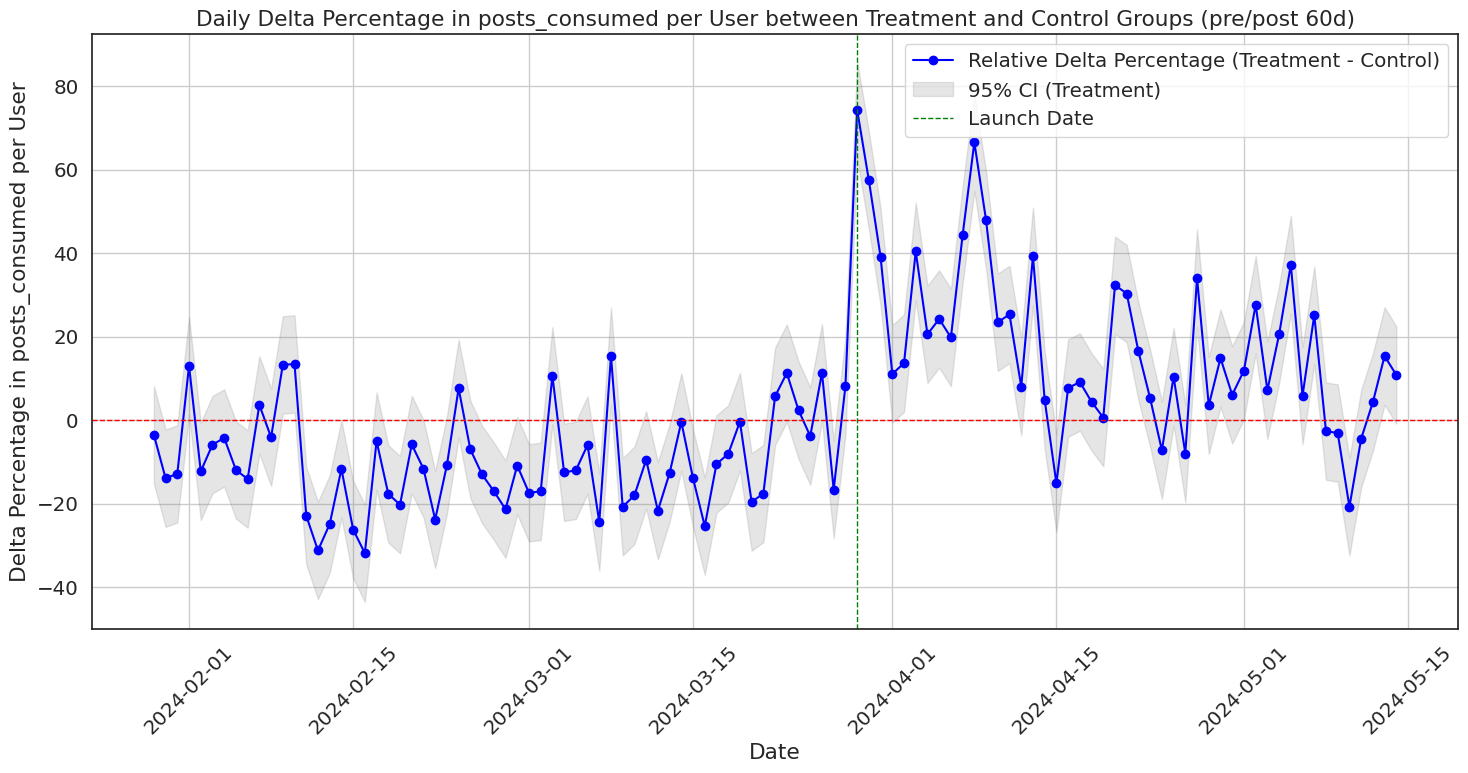

group,control,treatment,absolute_delta,relative_delta,treatment_ci,control_ci
pt,,,,,,
2024-01-29,43.747287,42.195382,-1.551905,-3.547431,11.660586,6.495807
2024-01-30,43.127132,37.117229,-6.009903,-13.935317,11.660586,6.495807
2024-01-31,50.348837,43.866785,-6.482052,-12.874284,11.660586,6.495807
2024-02-01,39.852713,45.040853,5.188139,13.018284,11.660586,6.495807
2024-02-02,40.072868,35.143872,-4.928996,-12.300083,11.660586,6.495807
2024-02-03,43.468217,40.907638,-2.560579,-5.890693,11.660586,6.495807
2024-02-04,45.031008,43.104796,-1.926212,-4.277524,11.660586,6.495807
2024-02-05,48.911628,43.074600,-5.837028,-11.933824,11.660586,6.495807
2024-02-06,40.009302,34.353464,-5.655839,-14.136309,11.660586,6.495807


In [43]:
# mapping the posts_consumed data
df1 = cp_consumed60.copy()


# Optimize by getting unique values and creating a DataFrame of all possible combinations
all_combinations = pd.MultiIndex.from_product([df1['pt'].unique(), df_psm_group['user_id'].unique()], names=['pt', 'user_id']).to_frame(index=False)


# Merge all_combinations with df1 to get the posts_consumed data
df3 = pd.merge(all_combinations, df1, on=['pt', 'user_id'], how='left')


# Merge df3 with df_psm_group to add the group information
df3 = pd.merge(df3, df_psm_group, on='user_id', how='left')


# Fill NaN values based on column type
df3['posts_consumed'] = df3['posts_consumed'].astype('float').fillna(0)


# Release more RAM by deleting table no longer used
# del posts_consumed


# Convert 'group' to a categorical type for better memory usage and performance
df3['group'] = df3['group'].astype('category')


# record the end time
end_time = time.perf_counter()
# calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")


## --------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from IPython.display import display

# Winsorize the data
df3['posts_consumed'] = winsorize(df3['posts_consumed'], limits=[0.025, 0.025])

# Define the separation date
separation_date = pd.to_datetime('2024-03-29')

# Split the data into 'pre' and 'post' periods
pre_df = df3[df3['pt'] < separation_date]
post_df = df3[df3['pt'] >= separation_date]

# Calculate metrics for 'tos' for pre and post periods
pre_metrics = calculate_metrics(pre_df, 'posts_consumed')
post_metrics = calculate_metrics(post_df, 'posts_consumed')

# Combine metrics into a single DataFrame for 'posts_consumed'
overall_metrics = pd.DataFrame({
    'aggregation': pre_metrics.index,
    'pre': pre_metrics.values,
    'post': post_metrics.values
}).set_index('aggregation')

# Print overall metrics for 'posts_consumed'
print("Overall Metrics for 'posts_consumed':")
print(overall_metrics)

# ---------------- craete a daily aggragate table
# Plotting (for each day if needed for comparison)
daily_avg = df3.groupby(['pt', 'group'])['posts_consumed'].mean().unstack()

# Calculate the absolute delta
daily_avg['absolute_delta'] = daily_avg['treatment'] - daily_avg['control']

# Calculate the relative delta percentage
daily_avg['relative_delta'] = (daily_avg['absolute_delta'] / daily_avg['control']) * 100

# Calculate means and standard errors for daily data
means = daily_avg.mean()
std_errors = daily_avg.std() / np.sqrt(daily_avg.count())

# Calculate confidence intervals for delta percentage for daily data
confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)  # Define z_score in the global scope
daily_avg['treatment_ci'] = z_score * (std_errors['treatment'] / means['treatment']) * 100
daily_avg['control_ci'] = z_score * (std_errors['control'] / means['control']) * 100

# ---------------------------------------
# Plotting
plt.figure(figsize=(15, 8))

# Plot delta percentage
plt.plot(daily_avg.index, daily_avg['relative_delta'], label='Relative Delta Percentage (Treatment - Control)', color='blue', marker='o')

# Plot confidence interval
plt.fill_between(daily_avg.index, daily_avg['relative_delta'] - daily_avg['treatment_ci'], daily_avg['relative_delta'] + daily_avg['treatment_ci'],
                 color='gray', alpha=0.2, label='95% CI (Treatment)')

# Add vertical line for launch date
plt.axvline(x=separation_date, color='green', linestyle='--', linewidth=1, label='Launch Date')

plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Percentage in posts_consumed per User')
plt.title('Daily Delta Percentage in posts_consumed per User between Treatment and Control Groups (pre/post 60d)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Display the daily metrics
display(daily_avg)
